# TEM Image Processing Pipeline

In this notebook we implement an image processing pipeline to extract information from transmission electron microscopy images of barium titanate nanoparticles in a low density polyethylene _matrix_. Information gained from this process includes the:
- number of particles, $N_p$
- number of agglomerates, $N_a$
- size of particles (longest and shortest chord lengths)
- locations of particles (x,y)
- number of particles per agglomerate, $n$
- factor of agglomeration

where factor of agglomeration is given by:
$$F_a = \frac{N_a \cdot n}{N_p}$$

## 1. Import necessary libraries and setup

In [1]:
# for timing how long it takes to import libraries
import time
t_lib_init = time.perf_counter()

import cv2 as cv                   # OpenCV for image processing
import matplotlib.pyplot as plt    # Matplotlib for visualizing
import numpy as np                 # NumPy for quick maths
from collections import Counter

t_lib_final = time.perf_counter()

print("time to import libraries:", str(t_lib_final - t_lib_init), "seconds")

time to import libraries: 0.8719023280136753 seconds


Define nm per pixel

In [2]:
# In TES-II-36a.tif there are 113 pixels per 100 nm
# In Challenge_1.jpg there are 92 pixels per 200nm = 46 pixels per 100 nm

t_pipe_init = time.perf_counter()

nm_per_pixel = 100 / 46
# nm_per_pixel = 100 / 113
print(str(nm_per_pixel), "nm per pixel")

2.1739130434782608 nm per pixel


## 2. Load input data and apply grayscale

We don't need to process input image with 3 color channels as TEM images tend to be grayscale. Now each pixel will be 8 bits ranging from 0 (light) to 255 (dark).

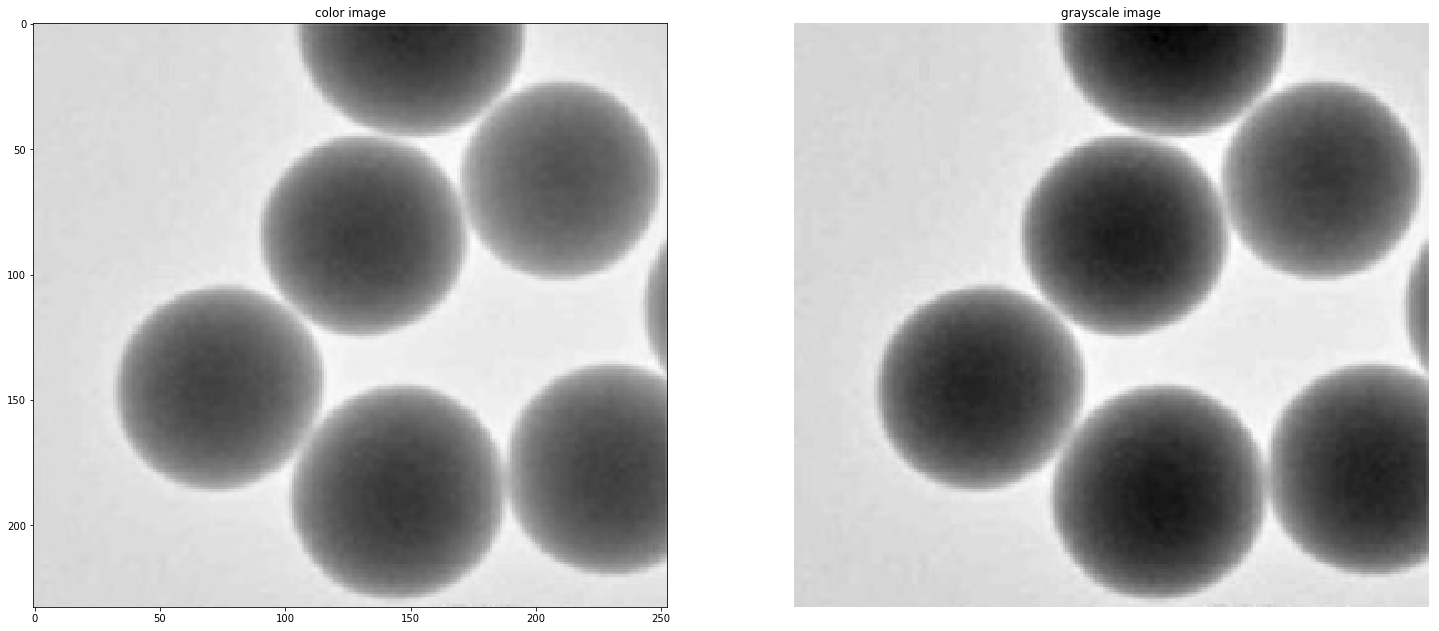

In [3]:
# display images inline in notebook, comment can't be on same line (glitch)
%matplotlib inline 

# IMAGE_NAME = "TES-36a-cropped.tif"
IMAGE_NAME = "Challenge_1.jpg"

color_image = cv.imread(IMAGE_NAME)
gray_image = cv.cvtColor(color_image, cv.COLOR_BGR2GRAY)

# plot input and grayscale input
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(25,25))
plt.axis("off")
ax0.imshow(color_image)
ax0.set_title("color image");
# ax1.imshow(gray_image)
ax1.imshow(gray_image, cmap = plt.cm.gray) 
ax1.set_title("grayscale image");

In [4]:
# reshape images to be a ndarray of pixels
# color_pixels = color_image.reshape((color_image.shape[0] * color_image.shape[1], 3))
# gray_pixels = color_image.reshape((gray_image.shape[0] * gray_image.shape[1], 3))

## 3. Gaussian blur 

TEM images have noise (looks like a fine grain filter accross image). To smooth out these grains we apply a gaussian blur.

TODO: explain kernel matrix

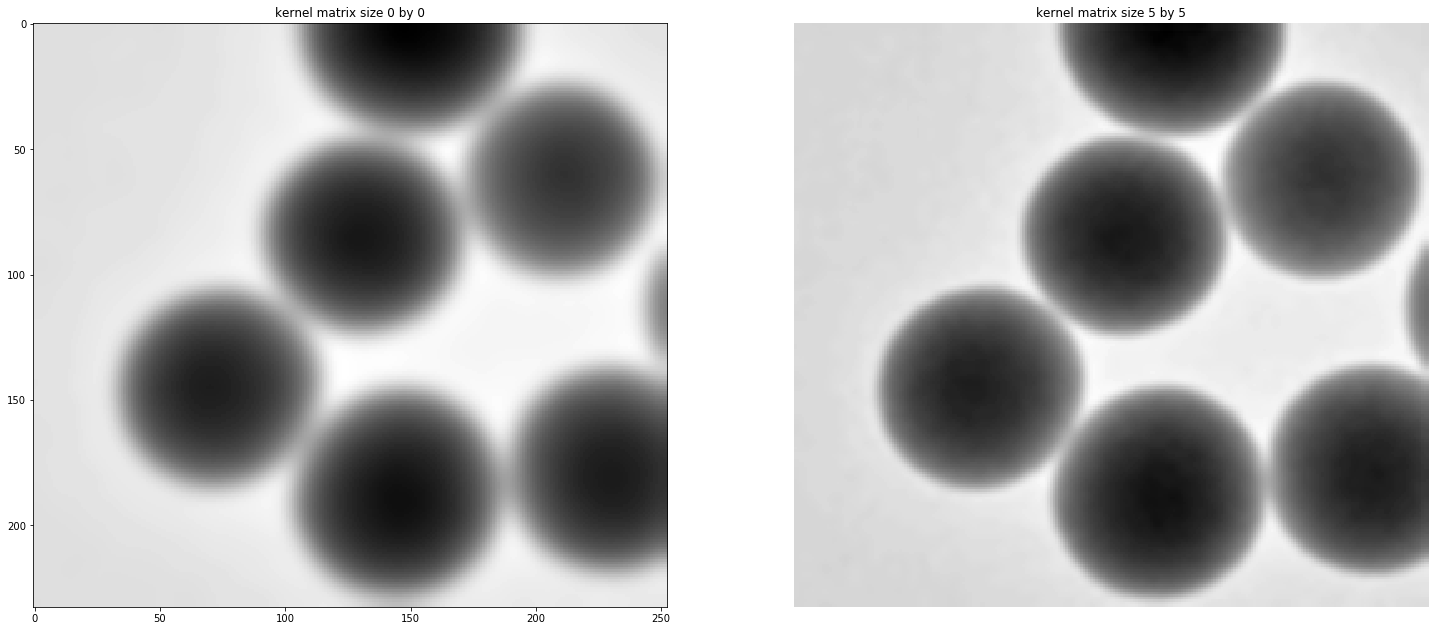

In [5]:
# apply gaussian blur
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(25,25))
plt.axis("off")
blur_1 = cv.GaussianBlur(gray_image, (0,0) ,cv.BORDER_DEFAULT) 
ax0.imshow(blur_1, cmap = plt.cm.gray) 
ax0.set_title("kernel matrix size 0 by 0")
blur_2 = cv.GaussianBlur(gray_image, (5,5) ,cv.BORDER_DEFAULT) # why only (0,0), (1,1), (5,5) work?
ax1.imshow(blur_2, cmap = plt.cm.gray)
ax1.set_title("kernel matrix size 5 by 5")

## 4. Binary Threshold 

Convert grayscale pixels to only take on values of 0 (light) or 1 (dark). This helps us reduce image size for faster processing but also results in a significant loss of information from the original image.

TODO: explain OTSU's method

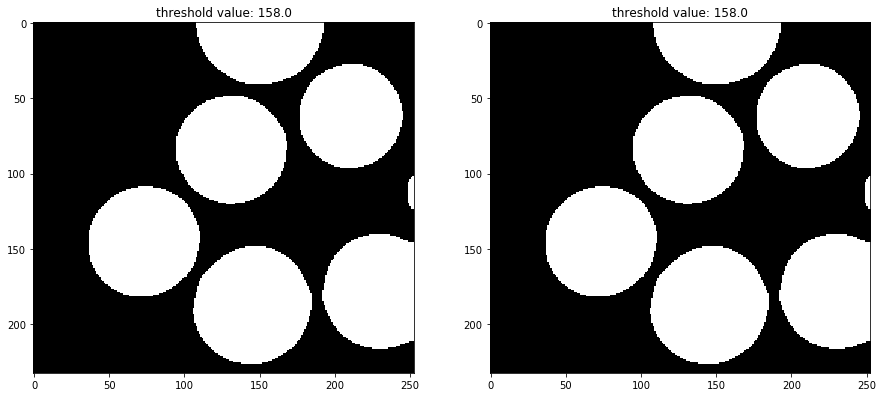

In [6]:
# auto binary threshold color image
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15,15))
ret_1, thresh_1 = cv.threshold(blur_1, 158, 255, cv.THRESH_BINARY_INV)
ax0.imshow(thresh_1, cmap = plt.cm.gray)
ax0.set_title("threshold value: " + str(ret_1));

# auto binary threshold grayscale image with Otsu’s method
ret_2, thresh_2 = cv.threshold(blur_1, 120, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)
ax1.imshow(thresh_2, cmap = plt.cm.gray)
ax1.set_title("threshold value: " + str(ret_2));

Calculate white to black ratio for all possible threshold values

In [7]:
# # store every threshold value's num white pixels / # num black pixels
# white_to_black = []

# # loop through all possible threshold values
# for i in range(256):
#     current_ret, current_thresh = cv.threshold(blur_1, i, 1, cv.THRESH_BINARY_INV)
#     # keep track of # white pixels
#     sum_white = 0
#     for row in current_thresh:
#         sum_white += np.sum(row)
#     white_to_black += [sum_white / current_thresh.size]

Plot white to black ratio for all possible threshold values

In [8]:
# # plot white to black ratio for all threshold values
# fig, axs = plt.subplots(1, 1, figsize=(7,7))
# axs.set_title("white to black ratio for all possible threshold values")
# axs.plot([x for x in range(256)], white_to_black)

## 5. Contours derived from sure background & foreground

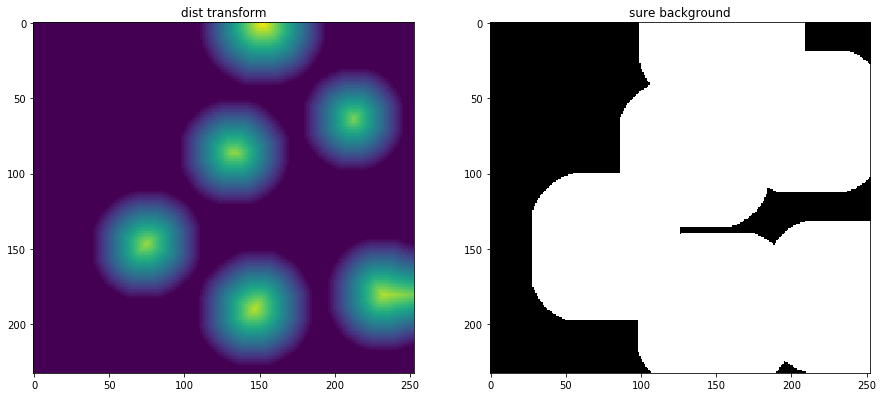

In [9]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15,15))

# noise removal
kernel = np.ones((10,10),np.uint8)
opening = cv.morphologyEx(thresh_1,cv.MORPH_OPEN,kernel, iterations = 2)

# sure background area
sure_bg = cv.dilate(opening,kernel,iterations=3)
ax1.imshow(sure_bg, cmap = plt.cm.gray)
ax1.set_title("sure background")

# Finding distance transform
# Lighter spots mean further away from contours
dist_transform = cv.distanceTransform(opening,cv.DIST_L2, 5)

ax0.imshow(dist_transform)
# ax0.imshow(unknown, cmap = plt.cm.gray)
ax0.set_title("dist transform")

### Threshold distance transform by the average value of intesities (TODO: unsure of where to use)

Get average value of intensities

In [10]:
# get sum of inensity values in distance transform
dist_sum = np.sum(dist_transform)
# get count of nonzero intensities in distance transform
nonzero_counter = Counter()
for row in dist_transform:
    nonzero_counter += Counter(row)
nonzero_count = len(dist_transform)*len(dist_transform[0]) - nonzero_counter[0.0]

print(dist_sum, nonzero_count)
average_value = dist_sum / nonzero_count

# dist_norm = np.zeros((len(dist_transform), len(dist_transform[0])))

# for row in range(len(dist_transform)):
#     for col in range(len(dist_transform[0])):
#         if dist_transform[row][col] <= average_half and dist_transform[row][col] >= 2:
#             dist_norm[row][col] += average_half
#         else:
#             dist_norm[row][col] -= average_value
            
# ax1.imshow(dist_norm, cmap=plt.cm.gray)
# ax1.set_title("normalized distance transform")

302666.1 23266


Threshold distance transform at average value

In [11]:
# fig, ax0 = plt.subplots(1, 1, figsize=(10,10))
# ret, dist_average = cv.threshold(dist_transform, 0.4*dist_transform.max(), 255, 0)
# ax0.imshow(dist_average, cmap=plt.cm.gray)
# ax0.set_title("thresholded with 0.4 x max value")

### Contour Agglomerates

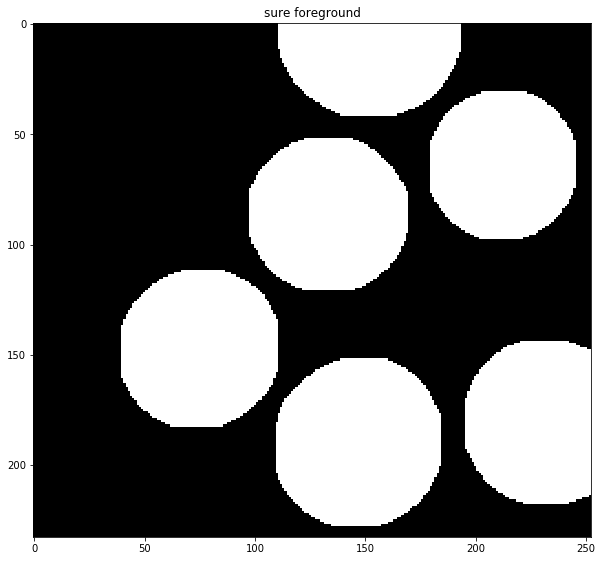

In [12]:
fig, axs = plt.subplots(1, 1, figsize=(10,10))

ret, sure_fg = cv.threshold(dist_transform, 0.01*dist_transform.max(), 255, 0)
axs.imshow(sure_fg, cmap = plt.cm.gray)
axs.set_title("sure foreground")

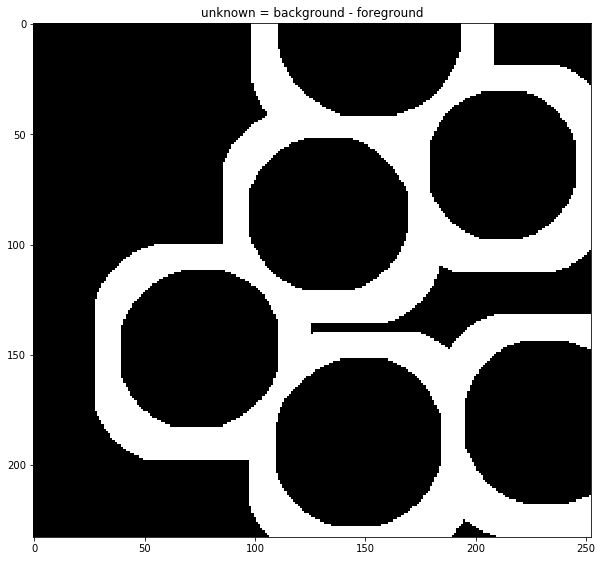

In [13]:
fig, axs = plt.subplots(1, 1, figsize=(10,10))

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv.subtract(sure_bg, sure_fg)

plt.imshow(unknown, cmap = plt.cm.gray)
axs.set_title("unknown = background - foreground")

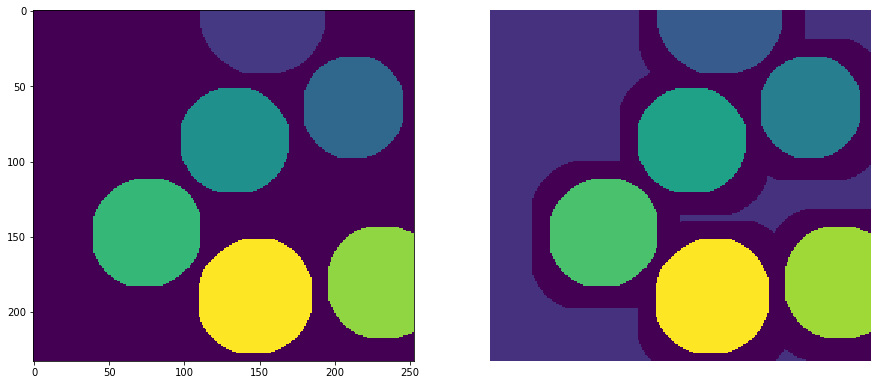

In [14]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15,15))
plt.axis("off")

# Marker labelling
ret, markers = cv.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
markers = markers+1
ax0.imshow(markers)

# If unknown's pixel is 255 (white), set corresponding pixel in markers to 0
markers[unknown==255] = 0
ax1.imshow(markers)

In [15]:
# copy input image
color_copy_1 = color_image.copy()

# TODO matrix multiplication optimization

for row in range(len(color_copy_1)):
    for col in range(len(color_copy_1[0])):
        if unknown[row][col] == 255:
            color_copy_1[row][col] = [255,0,0]

we set all boundary pixels to -1, then loop through all of them to make them red

then overlay red pixels on original image

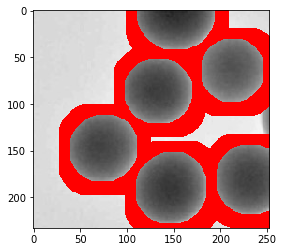

In [16]:
plt.imshow(color_copy_1)

### Contour particles 

Threshold distance transform with a higher value to get particle centers for watershed algorithm

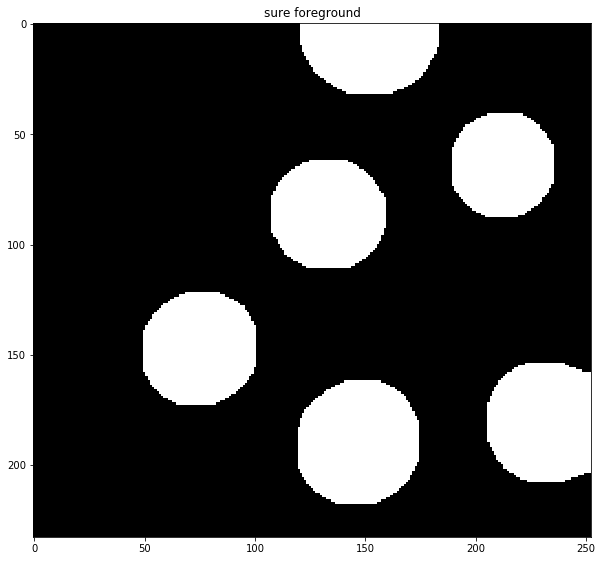

In [17]:
fig, axs = plt.subplots(1, 1, figsize=(10,10))

ret_2, sure_fg_2 = cv.threshold(dist_transform, 0.25*dist_transform.max(), 255, 0)
axs.imshow(sure_fg_2, cmap = plt.cm.gray)
axs.set_title("sure foreground")

In [18]:
# Finding unknown region
sure_fg_2 = np.uint8(sure_fg_2)
unknown_2 = cv.subtract(sure_bg, sure_fg_2)

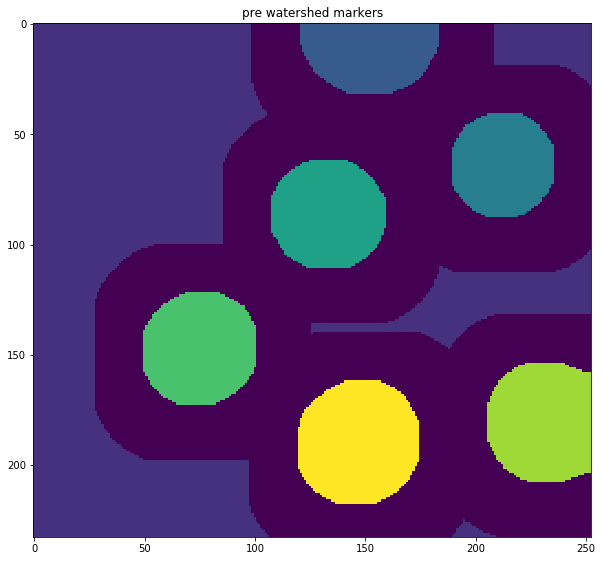

In [19]:
fig, axs = plt.subplots(1, 1, figsize=(10,10))

# Marker labelling
ret_2, pre_watershed_markers = cv.connectedComponents(sure_fg_2)
# Add one to all labels so that sure background is not 0, but 1
pre_watershed_markers = pre_watershed_markers+1
# Now, mark the region of unknown with zero
pre_watershed_markers[unknown_2==255] = 0

axs.imshow(pre_watershed_markers)
axs.set_title("pre watershed markers")

Run watershed algorithm from particle centers

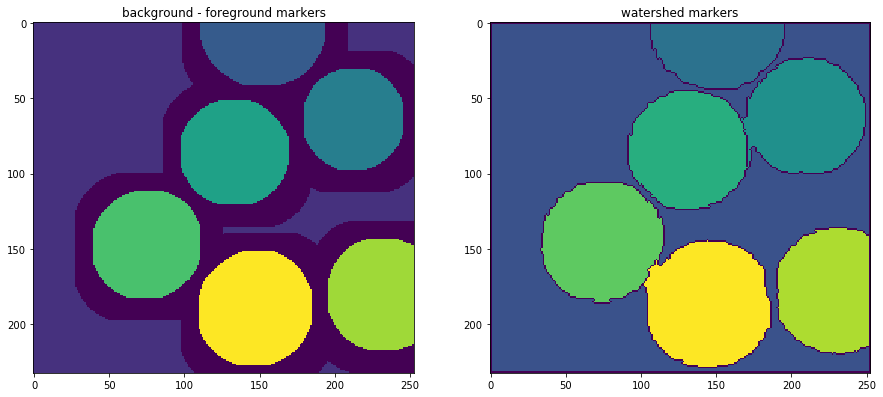

In [20]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15,15))

# copy input image
watershed_color_copy = color_image.copy()

watershed_markers = cv.watershed(watershed_color_copy, pre_watershed_markers)
watershed_color_copy[pre_watershed_markers == -1] = [255,0,0]

ax0.imshow(markers)
ax0.set_title("background - foreground markers")
ax1.imshow(watershed_markers)
ax1.set_title("watershed markers")

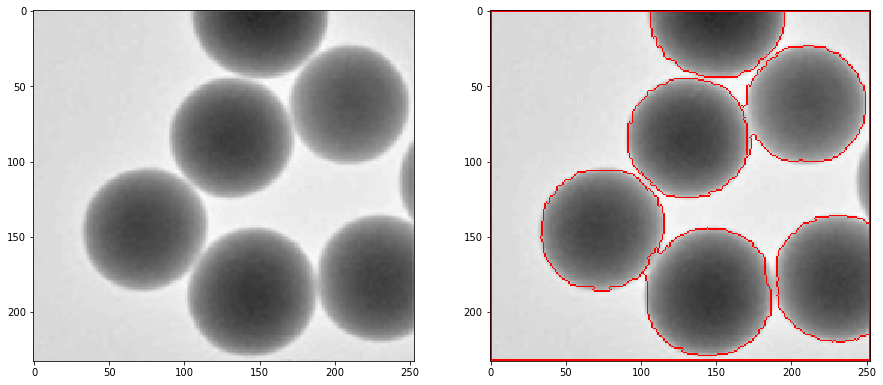

In [21]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15,15))

ax0.imshow(color_image)
ax1.imshow(watershed_color_copy)

## 6. Contours derived from Watershed algorithm

Markers pt.2 except this time they're derived from watershed instead of background - foreground

First obtain contour pixels and get their colors

In [22]:
# pixels are appended as (col, row) in order to feed to cv.lines() later on

# copy input image
chords_color_copy = color_image.copy()

# dictionary mapping colors to their pixels
contour_colors = {}

contour_size = 0
# loop through pixels in watershed markers
for row in range(1, len(watershed_markers) - 1):
    for col in range(1, len(watershed_markers[0]) - 1):
        # if pixel not in background
        if watershed_markers[row][col] != 1:
            # get current pixel and its neighbours 
            current = watershed_markers[row][col]
            up = watershed_markers[row-1][col]
            down = watershed_markers[row+1][col]
            left = watershed_markers[row][col-1]
            right = watershed_markers[row][col+1]
            # if not surrounded by uniform pixels
            if ((up != current) or (down != current) or (left != current) or (right != current)):
                # if the right pixel is different
                if (right != current):
                    # add current pixel to dictionary
                    if current not in contour_colors:
                        contour_colors[current] = [(col, row)]
                    else:
                        contour_colors[current] += [(col,row)]
                    
                    # if the right pixel is not in background, add it to the dictionary
                    if (right != 1):
                        if right not in contour_colors:
                            contour_colors[right] = [(col+1, row)]
                        else:
                            contour_colors[right] += [(col+1,row)]
                        chords_color_copy[row][col+1] = [255, 0, 0]
                        contour_size += 1
                        
                    chords_color_copy[row][col] = [255, 0, 0]
                    contour_size += 1
                    
                # if the down pixel is different
                elif (down != current):
                    # add current pixel to dictionary
                    if current not in contour_colors:
                        contour_colors[current] = [(col, row)]
                    else:
                        contour_colors[current] += [(col,row)]
                    
                    # if the down pixel is not in background, add it to the dictionary
                    if (down != 1):
                        if down not in contour_colors:
                            contour_colors[down] = [(col, row+1)]
                        else:
                            contour_colors[down] += [(col,row+1)]
                        chords_color_copy[row+1][col] = [255, 0, 0]
                        contour_size += 1
                        
                    chords_color_copy[row][col] = [255, 0, 0]
                    contour_size += 1
                
                # if the up or left pixel is different than the current pixel and is not a border pixel
                elif (((up != 255) and (up != current)) or ((left != 255) and (left != current))):
                    # add current pixel to dictionary
                    if current not in contour_colors:
                        contour_colors[current] = [(col, row)]
                    else:
                        contour_colors[current] += [(col,row)]
                        
                    chords_color_copy[row][col] = [255, 0, 0]                    
                    contour_size += 1

In [23]:
# remove -1 key from contour_colors because it represents bad contours drawn by cv.watershed()
del contour_colors[-1]

Then use list of pixels grouped by color to get chord lengths

In [24]:
# input pixels as tuples
def pixel_distance(pixel1, pixel2):
    return np.power(np.power(pixel1[0] - pixel2[0], 2) + np.power(pixel1[1] - pixel2[1], 2), 0.5)

In [25]:
# dictionary to map particles to their extracted information
particles = {}
# keep track of maximum chord length found
max_chord = 0

# store longest pairs as [[color, (start pixel), (end pixel)]]
longest_pairs = []
# loop through all colors
for color in contour_colors:
    # loop through all pixels in a color
    color_pixels = contour_colors[color]
    current_max = 0
    for i in range(len(color_pixels)):
        for j in range(len(color_pixels[i:])):
            distance = pixel_distance(color_pixels[i], color_pixels[j])
            if distance > current_max:
                current_max = distance
                longest_pair = [color, color_pixels[i], color_pixels[j]]
    # keep track of longest chord length pair for each color 
    longest_pairs += [longest_pair]
    # add to particles dictionary, accounting for nm per pixel
    particles[color] = [("a", (current_max / 2) * nm_per_pixel)]
    
    if current_max > max_chord:
        max_chord = current_max
            
print(longest_pairs)

[[2, (194, 1), (107, 11)], [3, (222, 25), (171, 95)], [4, (164, 61), (93, 97)], [5, (94, 109), (44, 173)], [6, (216, 138), (244, 217)], [7, (110, 158), (185, 202)]]


draw lines between longest chord lengths

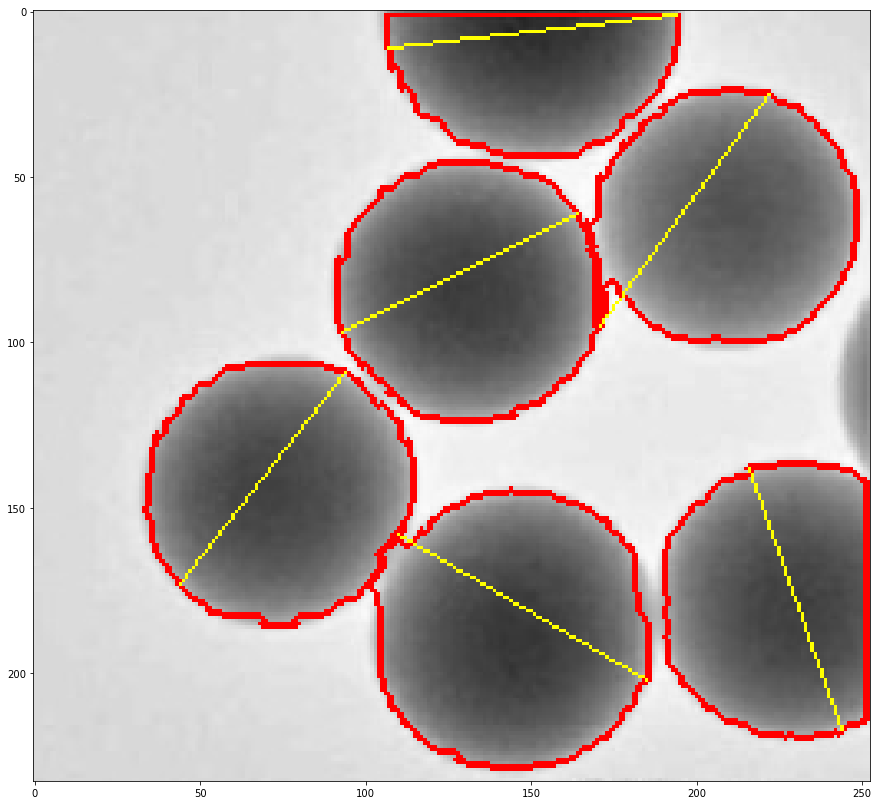

In [26]:
fig, axs = plt.subplots(1, 1, figsize=(15,15))

# loop through longest pairs and draw lines between pixel endpoints
for longest_pair in longest_pairs:
    cv.line(chords_color_copy, longest_pair[1], longest_pair[2], [255,255,0])

# display and save longest chord lengths image
axs.imshow(chords_color_copy)
# plt.savefig(IMAGE_NAME[7:-12] + "_longest_chords.png", dpi=500)
plt.savefig(IMAGE_NAME[:11] + "_longest_chords.png", dpi=500)

Visualizing contour for single color (14)

In [ ]:
# fig, axs = plt.subplots(1, 1, figsize=(15,15))
# # copy input image
# individual_markers_outline = color_image.copy()
# current_color = 14
# current_pixels = contour_colors[current_color]
# for row in range(len(individual_markers_outline)):
#     for col in range(len(individual_markers_outline[0])):
#         if (col, row) in current_pixels:
#             individual_markers_outline[row][col] = [255,0,0]
# axs.imshow(individual_markers_outline)

Obtain short chord lengths, calculating midpoints and rotations in X-Y plane on the way

In [ ]:
# all of below are sorted in ascending order of particle color
# store short chord length pair of points once found
short_pairs = []
# store scores (observed perpendicular slope vs. actual perpendicular slope)
scores = []
# keep track of each particle's centerpoints
centerpoints = []
# keep track of max x,y coordinates
max_x = 0
max_y = 0

# loop through longest pairs to get midpoint for each pair and then perpendicular short pairs
for pair in longest_pairs:
    # get all pixels of a color
    current_pixels = contour_colors[pair[0]]
    # get start & end x,y coordinates
    x1 = pair[1][0]
    y1 = pair[1][1]
    x2 = pair[2][0]
    y2 = pair[2][1]
    # calculate slope as rise over run
    slope = (y2-y1) / (x2-x1)
    # calculate orthogonal slope
    orthogonal_slope = -1 / slope
    # check which pixel start, which is end and calculate midpoint accordingly 
    if x1 > x2:
        mid_x = x2 + int((x1-x2) / 2)
    else:
        mid_x = x1 + int((x2-x1) / 2)
    if y1 > y2:
        mid_y = y2 + int((y1-y2) / 2)
        # calculate rotation in X-Y plane with long length's slope
        if x1 > x2:
            theta = 360 - np.arctan((y1-y2)/(x1-x2))*(180/np.pi)
        else:
            theta = 180 + np.arctan((y1-y2)/(x2-x1))*(180/np.pi)
    else:
        mid_y = y1 + int((y2-y1) / 2)
        # calculate rotation in X-Y plane with long length's slope
        if slope > 0:
            theta = -1*(180 - (np.arctan(slope)*(180/np.pi)))
        else:
            theta = np.arctan(slope)*(180/np.pi)
    
    # add X-Y rotation angle to particles dictionary
    particles[pair[0]] += [("theta", theta)]
    
    short_pair = []
    current_score = []
    sum_x = 0
    sum_y = 0
    # loop through all pixels for a color
    for pixel in current_pixels:
        # add x and y coordinates to running sum for particle
        sum_x += pixel[0]
        sum_y += pixel[1]
        
        # calculate change in x and y with respect to midpoint for pixel
        dx = pixel[0] - mid_x
        dy = pixel[1] - mid_y
        # change in x cannot be 0
        if dx != 0:
            # compute slope between pixel and midpoint
            comp_slope = dy/dx
            # score ~= ratio of pixel slope / orthogonal slope from long chord length
            score = np.abs(1 - comp_slope / orthogonal_slope)
            # set threshold that pixel slope / orthogonal slope must be < 0.5
            if (score < 0.5):
                # if pixel isn't already in short_pair
                if pixel not in short_pair:
                    short_pair += [pixel]
                    current_score += [score]
                    
    # add x and y centerpoints to particles dictionary, accounting for nm per pixel
    center_x = sum_x / len(current_pixels)
    center_y = sum_y / len(current_pixels)
    particles[pair[0]] += [("x", center_x*nm_per_pixel)]
    particles[pair[0]] += [("y", center_y*nm_per_pixel)]

    # find max x,y coordinates
    # if x-coordinate of midpoint + that particles longest chord length > max x-coordinate observed
    if center_x + particles[pair[0]][0][1] > max_x:
        # add 1 for extra room & caution
        max_x = center_x + particles[pair[0]][0][1] + 1
    if center_y + particles[pair[0]][0][1] > max_y:
        # add 1 for extra room & caution
        max_y = center_y + particles[pair[0]][0][1] + 1
    
    # record pair of points of short chord length
    short_pairs += [short_pair]
    # record each pair of points' scores
    scores += [current_score]

Now that we have a list of pixels and their scores, let's find the best two which will be our short chord lengths

In [ ]:
# store min pixel pairs to visualize lines
min_pixel_pairs = []
    
# process pairs to keep ones with min score
for i in range(len(short_pairs)):
    if len(short_pairs[i]) >= 2:
    #     first find pixel with overall minimum
        min_index_1 = np.argmin(scores[i])
        min_pixel_1 = short_pairs[i][min_index_1]
        
        # now loop through rest of pixels to find far away pixel with low score
        min_distance = 10 # TODO: generalize for different particle sizes
        for j in range(len(short_pairs[i])):
            distance = pixel_distance(min_pixel_1, short_pairs[i][j])
            if distance > min_distance:
                min_pixel_2 = short_pairs[i][j]
                
                # store pixels for cv.line() later
                min_pixel_pairs += [[min_pixel_1, min_pixel_2]]
                
                # longest_pairs[i][0] is current color
                # add short distance to particles dictionary, accounting for nm per pixel
                particles[longest_pairs[i][0]] += [("b", (distance/2)*nm_per_pixel)] 
                break

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(15,15))

# copy input image
midpoint_test = color_image.copy()

for short_pair in min_pixel_pairs:
    cv.line(chords_color_copy, short_pair[0], short_pair[1], [0,255,255])

axs.imshow(chords_color_copy)

# plt.savefig(IMAGE_NAME[7:-12] + "_perpendicular_chords_0.5.png", dpi=500)
plt.savefig(IMAGE_NAME[:11] + "_perpendicular_chords_0.5.png", dpi=500)

Average long and short chord lengths to get z-axis chord length and obtain volume of ellipsoid as: 
$$\frac{4}{3}\pi \cdot abc$$
where a,b,c are the radii in the respective x,y,z dimensions

In [ ]:
# loop through particles dictionary and set c length to be the average of a and b lengths
max_c = 0
for particle in particles:
    particle_data = particles[particle]
    if len(particle_data) == 5:
        # c = a + b / 2
        c_radius = (particle_data[0][1] + particle_data[-1][1]) / 2
        particles[particle] += [("c", c_radius)]
        if c_radius > max_c:
            max_c = c_radius

# setting z coordinate to maximum c radius + 1 so no particles will intersect with copper plate in COMSOL model
# setting volume of particle as volume of ellipsoid
total_volume = 0
for particle in particles:
    particle_data = particles[particle]
    # if all other data was extracted corectly for a particle
    if len(particle_data) == 6:
        current_volume = (4/3)*np.pi*particles[particle][0][1]*particles[particle][4][1]*particles[particle][5][1]
        particles[particle] += [("z", ((max_chord / 2) * nm_per_pixel) + 1), ("volume", current_volume)]
        total_volume += current_volume
        print(particles[particle])

## 7. Save output as .txt for COMSOL

In [ ]:
# filename = IMAGE_NAME[7:-12] + "_COMSOL_input.txt"
filename = IMAGE_NAME[:11] + "_COMSOL_input.txt"

# sample output
# output = [("a", 1000, 78), ("x", 1000, 70), ("y", 1000, 500), ("z", 1000, 75), ("b", 1000, 169), ("c", 1000, 103)]

# save output as e.g. a3000 100[nm] where a/b/c is chord length direction, 3000 is particle number, 100[nm] is 
output_file = open(filename, "w")
i = 1 # need 
for particle in particles:
    particle_data = particles[particle]
    if len(particle_data) == 8:
        output_file.writelines(particle_data[0][0] + str(i) + " " + str(particle_data[0][1]) + "[nm]" + "\n")      # a
        output_file.writelines(particle_data[4][0] + str(i) + " " + str(particle_data[4][1]) + "[nm]" + "\n")      # b
        output_file.writelines(particle_data[5][0] + str(i) + " " + str(particle_data[5][1]) + "[nm]" + "\n")      # c
        output_file.writelines(particle_data[2][0] + str(i) + " " + str(particle_data[2][1]) + "[nm]" + "\n")      # x
        output_file.writelines(particle_data[3][0] + str(i) + " " + str(particle_data[3][1]) + "[nm]" + "\n")      # y
        output_file.writelines(particle_data[6][0] + str(i) + " " + str(particle_data[6][1]) + "[nm]" + "\n")      # z
        output_file.writelines(particle_data[1][0] + str(i) + " " + str(particle_data[1][1]) + "[degrees]" + "\n") # theta
        output_file.writelines(particle_data[7][0] + str(i) + " " + str(particle_data[7][1]) + "[nm^3]" + "\n")    # volume
        i += 1
output_file.writelines("*****************\n")
output_file.writelines("total_volume " + str(total_volume) + "[nm^3]" + "\n")        # total volume
output_file.writelines("cube_length " + str(np.max([max_x, max_y])*nm_per_pixel) + "[nm]" + "\n")    # cube side length
output_file.close()

t_pipe_final = time.perf_counter()

In [ ]:
print("time to run pipeline:", str(t_pipe_final - t_pipe_init), "seconds")